In [2]:
libs <- c(
    'dplyr',
    'tidyr',
    'stringr',
    'ggplot2',
    'GenomicRanges',
    'RPostgreSQL',
    'doMC',
    'numbers',
    'doParallel'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

library(BSgenome.Hsapiens.UCSC.hg38)
hg38 <- BSgenome.Hsapiens.UCSC.hg38

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
source("/ssd/mrichard/github/BDDS/trenadb/src/utils.R")
source("/ssd/mrichard/github/BDDS/footprints/testdb/src/dbFunctions.R")

We'll start by loading our positive/negative data from the previous notebook. Remember that this contains:

1. Information for 55 TFs that appear in the ChipSeq, our mapping of TF-motif, and JASPAR motifs
2. Positives: FIMO instances of the motifs from these TFs that have hits (overlaps) with ChipSeq
3. Negatives: FIMO instances of the motifs from these TFs that don't overlap with ChipSeq

Recall that we took 9 times as many negatives as positives, when possible

In [3]:
load("/ssd/mrichard/data/all.TF.fimo.samples.ratio.9.df.RData")

We're also going to load up the lymphoblast databases; basically, we've been doing all of this in a tissue-agnostic way. We're going to now bring the footprinting into it. And I think lymphoblast is the pertinent tissue

*Note that the lymphoblast stuff below is with the previous database; might want to do this with the new ones!

In [4]:
db_lymph_hint <- src_postgres(drv=dbDriver("PostgreSQL"),
                              user="trena",
                              password="trena",
                              dbname = "lymphoblast_hint_16", #Use Seed 16
                              host = "localhost")
db_lymph_well <- src_postgres(drv=dbDriver("PostgreSQL"),
                              user="trena",
                              password="trena",
                              dbname = "lymphoblast_wellington_16", # Use Seed 16
                              host = "localhost")
hint_regions <- tbl(db_lymph_hint, "regions")
hint_hits    <- tbl(db_lymph_hint, "hits")
well_regions <- tbl(db_lymph_well, "regions")
well_hits    <- tbl(db_lymph_well, "hits")

## function to loop over all chromosomes

We've got HINT and Wellington; we want to merge these together, so we do the following in a function, for a given chromosome number:

1. Grab all the FIMO entries for that chromosome (this is BIG!)
2. For HINT and Wellington, join the regions and hits tables (adds chromosome to hits), and grab just the start, end, strand, motif name, and method-specific score.
3. For a given unique start/end/strand, you can have multiple hits. So count how many hits each location has and store that number, plus grab the maximum score. Do this for both HINT and Wellington to reduce the number of rows and keep just the most important score info (max and frequency)
4. Merge together the FIMO, HINT, and Wellington tables; so now each motif instance in FIMO is listed with how many hits it had in HINT/Wellington and what its max score was in each case. Return this useful data frame!

In [5]:
merge_fimo_hint_wellington_one_chrom <- function(chrom_str,
                                                 fimo_tbl,
                                                 hint_regions_tbl,
                                                 hint_hits_tbl,
                                                 well_regions_tbl,
                                                 well_hits_tbl
                                                ) {
    
    # some tables use chr22 and some just use 22
    chrom_long_str = paste("chr",chrom_str, sep="")
    
    # select one chromosome from my data table
    fimo_tbl %>%
    filter(chrom==chrom_str) %>%
    select(-empty) ->
    chrom_all_tf_df
    
    # select one chromosome from hint
    hint_regions_tbl %>%
    filter(chrom==chrom_long_str) %>%
    left_join(hint_hits_tbl, by="loc") %>%
    as.data.frame %>%
    as.tbl %>%
    select(start, endpos, strand, name, score1) %>%
    rename("score1"="h_score") ->
    chrom_hint_all_tbl

    # select one chromosome from wellington
    well_regions_tbl %>%
    filter(chrom==chrom_long_str) %>%
    left_join(well_hits_tbl, by="loc") %>%
    as.data.frame %>%
    as.tbl %>%
    select(start, endpos, strand, name, score1) %>%
    rename("score1"="w_score") ->
    chrom_well_all_tbl
    
    # keep only max hint score but count total nontrivial scores
    chrom_hint_all_tbl %>%
    group_by(start, endpos, name, strand) %>%
    mutate(h_count = n()) %>%
    group_by(start, endpos, name, strand) %>%
    mutate(h_max_score = max(h_score)) %>%
    distinct(start, endpos, name, strand, .keep_all = TRUE) %>%
    select(-h_score) ->
    chrom_hint_unique_tbl

    # keep only min wellington score but count total nontrivial scores
    chrom_well_all_tbl %>%
    group_by(start, endpos, name, strand) %>%
    mutate(w_count = n()) %>%
    group_by(start, endpos, name, strand) %>%
    mutate(w_min_score = min(w_score)) %>%
    distinct(start, endpos, name, strand, .keep_all = TRUE) %>%
    select(-w_score) ->
    chrom_well_unique_tbl
    
    # merge hint and wellington into my table
    chrom_all_tf_df %>%
    left_join(chrom_hint_unique_tbl, by=c("start", "endpos", "strand", "motifname"="name")) %>%
    left_join(chrom_well_unique_tbl, by=c("start", "endpos", "strand", "motifname"="name")) %>%
    replace_na(list(h_count=0, w_count=0, h_max_score=0, w_min_score=0)) ->
    chrom_all_tf_df_merged
    
    return(chrom_all_tf_df_merged)
    
}

## Perform loop over all chromosomes

*** I'm pretty sure we can parallelize this ***

Doing the loop, we now have a really big data frame. We feed in the version of FIMO that essentially has positives/negatives based on ChipSeq; this is the basis we're starting with. So now what we have is:

* A data frame of motifs from our ChipSeq TF set, marked as "positives" or "negatives" WRT ChipSeq hits
* The number of hits each method (HINT/Wellington) has with each motif
* The maximum score (in absolute value; Wellington is negative, so it's technically the minimum) for each method
* All the other meta data (strand, start/end, sequence, motif score, motif name)

In [6]:
big_df <- tibble()

# I added X and Y here too
for (chr_str in as.character(c(1:22,"X","Y"))) {
    message(paste("working on chromosome",chr_str))
    
    df <- merge_fimo_hint_wellington_one_chrom(chr_str,
                                               all.TF.df,
                                               hint_regions,
                                               hint_hits,
                                               well_regions,
                                               well_hits)
    big_df <- rbind(big_df, df)
}

working on chromosome 1
working on chromosome 2
working on chromosome 3
working on chromosome 4
working on chromosome 5
working on chromosome 6
working on chromosome 7
working on chromosome 8
working on chromosome 9
working on chromosome 10
working on chromosome 11
working on chromosome 12
working on chromosome 13
working on chromosome 14
working on chromosome 15
working on chromosome 16
working on chromosome 17
working on chromosome 18
working on chromosome 19
working on chromosome 20
working on chromosome 21
working on chromosome 22
working on chromosome X
working on chromosome Y


In [7]:
str(big_df)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	24720556 obs. of  14 variables:
 $ motifname  : chr  "Mmusculus-jaspar2016-Nfe2l2-MA0150.2" "Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1" "Hsapiens-jaspar2016-JUND(var.2)-MA0492.1" "Hsapiens-jaspar2016-ATF7-MA0834.1" ...
 $ chrom      : chr  "1" "1" "1" "1" ...
 $ start      : int  1677938 1677939 1828558 2255916 2255789 2255823 2255891 2255917 2255949 2255983 ...
 $ endpos     : int  1677952 1677953 1828572 2255929 2255803 2255837 2255905 2255931 2255963 2255997 ...
 $ strand     : chr  "+" "+" "-" "-" ...
 $ motifscore : num  13.35 11.71 9.73 8.03 13.72 ...
 $ pval       : num  1.13e-05 1.37e-05 9.18e-05 6.68e-05 1.48e-05 1.48e-05 1.48e-05 8.28e-06 1.48e-05 1.48e-05 ...
 $ sequence   : chr  "CACTGTGACTCCGCA" "ACTGTGACTCCGCAG" "TTTTGTGAGGTCACT" "AAATGAGGTCACTG" ...
 $ loc        : chr  "chr1:1677938-1677952" "chr1:1677939-1677953" "chr1:1828558-1828572" "chr1:2255916-2255929" ...
 $ cs_hit     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ h_count    : num  

## Rename and save

Doing this took a lot of time (as in hours); we'll save it in this file as "big_df" for later

In [8]:
all.TF.df.fimo.hint.well <- big_df
save(all.TF.df.fimo.hint.well, file="/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed16.9.Rdata")

## Explore data

We're going to explore our big data frame in 3 plots:

1. Looking at the density of both positive and negative as a function of Wellington score (asinh-transformed)
2. Looking at the density of both positive and negative as a function of HINT score (asinh-transformed)
3. Looking at Wellington score vs. HINT score for both positive and negative

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


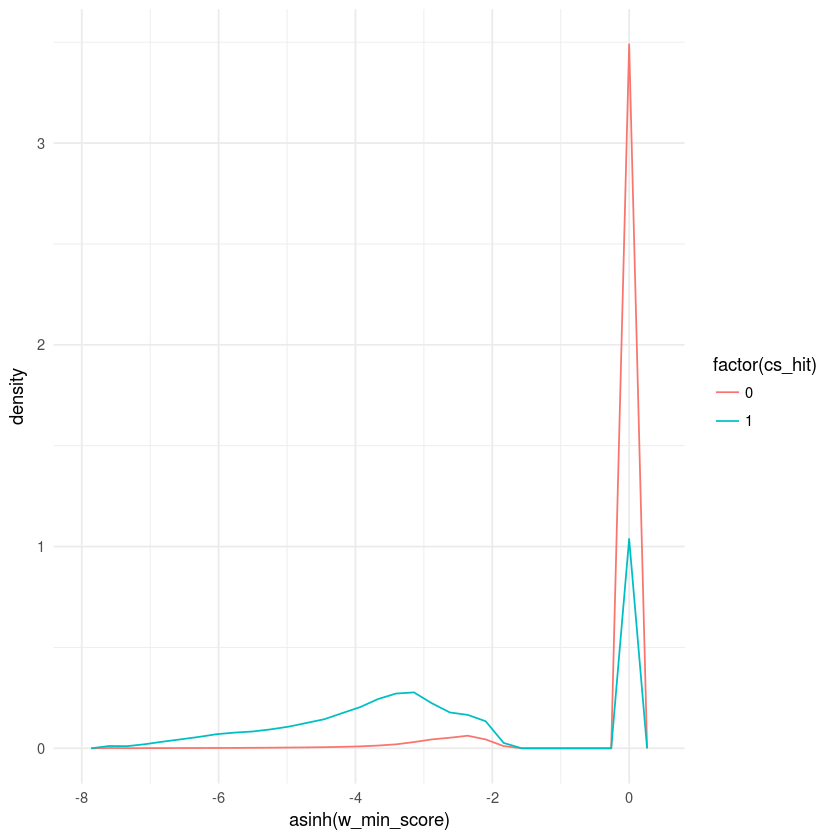

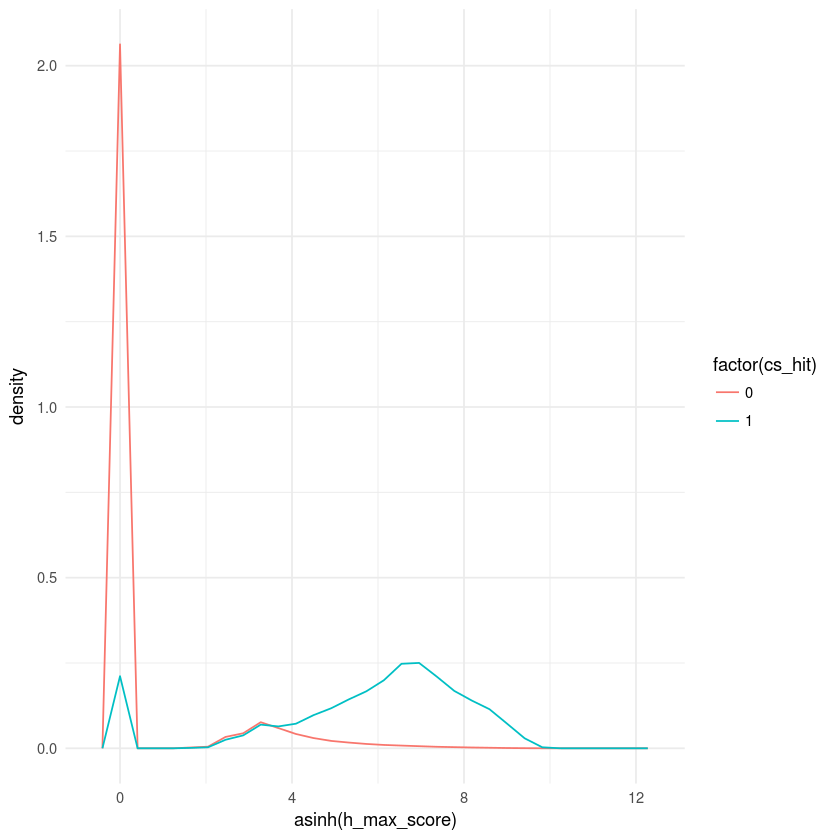

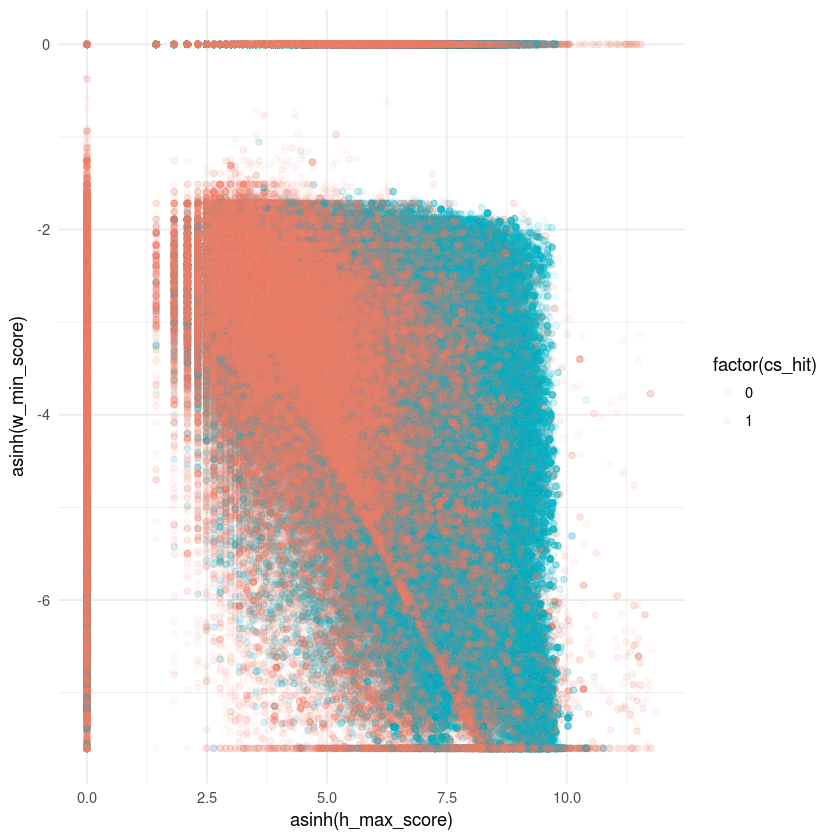

In [9]:
all.TF.df.fimo.hint.well %>%
ggplot +
geom_freqpoly(aes(x=asinh(w_min_score), y= ..density.., color=factor(cs_hit))) +
theme_minimal()

all.TF.df.fimo.hint.well %>%
ggplot +
geom_freqpoly(aes(x=asinh(h_max_score), y= ..density.., color=factor(cs_hit))) +
theme_minimal()

all.TF.df.fimo.hint.well %>%
ggplot +
geom_point(
    aes(x=asinh(h_max_score),
        y=asinh(w_min_score),
        color=factor(cs_hit)),
    alpha=0.05) +
theme_minimal()